# Exercise - Knowledge Base Agent - STARTER

In this exercise, you’ll build a Knowledge Base Agent using LangGraph, which can:

Efficiently process long documents using text embedding and chunking.
Retrieve information from a vector database.
Augment user queries with retrieved contextual documents.
Generate accurate responses using an LLM.


**Challenge**

Your task is to create a LangGraph Workflow that includes:

- A document loading and vectorization process for a knowledge base.
- An Agent Node capable of:
    - Retrieving relevant knowledge.
    - Augmenting responses with contextual documents.
    - Generating accurate answers.
- Conditional routing to control query resolution.
- Optimization techniques such as text chunking and embedding search.

By the end of this exercise, you’ll have built an AI-powered Knowledge Base Agent that uses a structured process to generate accurate answers.



## 0. Import the necessary libs

In [1]:
!pip install pysqlite3-binary
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
!pip install chromadb
!pip install langchain-chroma


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install sentence_transformers


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install pypdf


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [4]:
from typing import List
import chromadb
from chromadb.utils import embedding_functions
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from IPython.display import Image, display

/opt/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
OPENAI_API_KEY="voc-"

## 1. Instantiate Chat Model with your API Key

To be able to connect with OpenAI, you need to instantiate an ChatOpenAI client passing your OpenAI key.

You can pass the `api_key` argument directly.
```python
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key="voc-",
)
```

In [6]:
# TODO - Instantiate your chat model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key = OPENAI_API_KEY,
)

In [7]:
# TODO - Instantiate your embeddings model
embeddings_fn = OpenAIEmbeddings(
    model="text-embedding-3-large",
    api_key = OPENAI_API_KEY,
)

## 2. Load and Process Documents

In [8]:
# TODO create your Chroma vector store with a collection name 
# and the embedding function
vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings_fn,
)

In [9]:
file_path = "compact-guide-to-large-language-models.pdf"

In [10]:
loader = PyPDFLoader(file_path)

In [11]:
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [12]:
# TODO - Create a text splitter with chunk_size and chunk_overlap 
# values of 1000 and 200, respectively
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

In [13]:
all_splits = text_splitter.split_documents(pages)

In [14]:
_ = vector_store.add_documents(documents=all_splits)

## 3. Define State Schema

We define a State Schema for managing:

- User query
- Retrieved documents
- Generated answer

In [15]:
# TODO - Create your state schema named State inheriting from MessagesState
# with question(str), documents(List) and answer(str) attributes
class State(MessagesState):
     question: str 
     documents: List[str]
     answer: str

## 4. RAG Nodes

The agent should:
- fetch relevant document chunks based on the user query
- combine the retrieved documents and use them as context
- invoke the LLM to generate a response

In [16]:
def retrieve(state: State):
    question = state["question"]

    # TODO - Use the vector store to retrieve similar documents to the question
    # Use the similarity_search() method
    
    retrieved_docs = vector_store.similarity_search(
        question, 
        k=3,
        filter={"source": "documents"},
        )
                 
    return {"documents": retrieved_docs}

In [17]:
def augment(state: State):
    question = state["question"]
    documents = state["documents"]
    docs_content = "\n\n".join(doc.page_content for doc in documents)

    # TODO - Create a RAG ChatPromptTemplate with question and context variables
    template = ChatPromptTemplate.from_messages(
        [
        ("system", "You're a helpful assistant."),
        ("human", "Tell me about {question}")
        ]
        )

    messages = template.invoke(
        {"context": docs_content, "question": question}
    ).to_messages()

    return {"messages": messages}

In [18]:
def generate(state: State):
    # TODO - Invoke the LLM passing the messages from state
    ai_message = llm.invoke(state["messages"])
    return {"answer": ai_message.content, "messages": ai_message}

## 5. Build the LangGraph Workflow

In [19]:
workflow = StateGraph(State)
# TODO - add all the nodes and edges

workflow.add_node("retrieve", retrieve)
workflow.add_node("augment", augment)
workflow.add_node("generate", generate)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "augment")
workflow.add_edge("augment", "generate")
workflow.add_edge("generate", END)

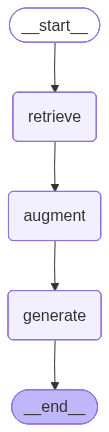

In [20]:
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

## 6. Invoke the Agent with a Query

Run and Print the retrieved documents to check search accuracy.

In [21]:
output = graph.invoke(
    {"question": "What are Open source models?"}
)

In [22]:
output["answer"]

"Open source models refer to software, algorithms, or frameworks whose source code is made publicly available for anyone to use, modify, and distribute. This concept is prevalent in various fields, including software development, machine learning, and data science. Here are some key aspects of open source models:\n\n### 1. **Accessibility**\n   - Open source models are accessible to anyone, which means that developers, researchers, and organizations can use them without needing to pay for licenses or permissions.\n\n### 2. **Collaboration**\n   - Open source encourages collaboration among developers and researchers. Many people can contribute to the development of a model, leading to improvements, bug fixes, and new features.\n\n### 3. **Transparency**\n   - The source code is available for inspection, which allows users to understand how the model works, identify potential biases, and verify its performance. This transparency can enhance trust in the model.\n\n### 4. **Customization**

In [23]:
for message in output["messages"]:
    message.pretty_print()

================================ System Message ================================

You're a helpful assistant.
================================ Human Message =================================

Tell me about What are Open source models?
================================== Ai Message ==================================

Open source models refer to software, algorithms, or frameworks whose source code is made publicly available for anyone to use, modify, and distribute. This concept is prevalent in various fields, including software development, machine learning, and data science. Here are some key aspects of open source models:

### 1. **Accessibility**
   - Open source models are accessible to anyone, which means that developers, researchers, and organizations can use them without needing to pay for licenses or permissions.

### 2. **Collaboration**
   - Open source encourages collaboration among developers and researchers. Many people can contribute to the development of a model, leading 

## 7. Experiment

Now that you understood how it works, experiment with new things.

- Change the embedding model
- Change the parameters of RecursiveCharacterTextSplitter(chunk_size and chunk_overlap)
- Use your own document
- Add More File Types